<a href="https://colab.research.google.com/github/TomJZ/DeepLearningForDynamics-Intuition/blob/main/RNN_lorenz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [31]:
import torch
from torch import nn
import numpy as np
!pip install torchdiffeq
from torchdiffeq import odeint
import matplotlib.pyplot as plt
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

# Visualization

In [276]:
def visualize_3d(obs=None, noiseless_traj=None,times=None, trajs=None, save=None, title=''):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    if title is not None:
      ax.set_title('Trajectory\n'+title)

    if noiseless_traj is not None:
      z = np.array([o for o in noiseless_traj])
      z = np.reshape(z, [-1,3])
      for i in range(len(z)):
        ax.plot(z[i:i+10, 0], z[i:i+10, 1], z[i:i+10, 2], color=plt.cm.jet(i/len(z)/1.6))

    if obs is not None:
      z = np.array([o for o in obs])
      z = np.reshape(z, [-1,3])
      ax.scatter(z[:,0], z[:,1], z[:,2], marker='.', color='k', alpha=0.5, linewidths=0, s=45)

    if trajs is not None:
      z = np.array([o for o in trajs])
      z = np.reshape(z, [-1,3])
      for i in range(len(z)):
        ax.plot(z[i:i+10, 0], z[i:i+10, 1], z[i:i+10, 2], color='r', alpha=0.3)

    fig.canvas.draw()
    fig.canvas.flush_events()
    plt.show()
    if save is not None:
        plt.savefig(save+'.png', format='png', dpi=400, bbox_inches ='tight', pad_inches = 0.1)
        pass

In [308]:
from logging import raiseExceptions
def visualize_2d(pred_y=None, true_y=None, odefunc=None):
    fig = plt.figure(figsize=(12, 4), facecolor='white')
    ax_traj = fig.add_subplot(131, frameon=False)
    ax_phase = fig.add_subplot(132, frameon=False)
    ax_vecfield = fig.add_subplot(133, frameon=False)
    if true_y is not None:
        t = np.arange(len(true_y))
    elif pred_y is not None:
        t = np.arange(len(pred_y))
    else:
        raiseExceptions("you need at least one traj")

    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('steps')
    ax_traj.set_ylabel('x,y')
    if true_y is not None:
        ax_traj.plot(t, true_y[:, 0, 0], t, true_y[:, 0, 1], 'g-')
    if pred_y is not None:
        ax_traj.plot(t, pred_y[:, 0, 0], '--', t, pred_y[:, 0, 1], 'b--')
    ax_traj.set_xlim(np.min(t), np.max(t))
    ax_traj.set_ylim(-2, 2)

    ax_phase.set_title('Phase Portrait')
    ax_phase.set_xlabel('x')
    ax_phase.set_ylabel('y')
    if true_y is not None:
        ax_phase.plot(true_y[:, 0, 0], true_y[:, 0, 1], 'g-')
    if pred_y is not None:
        ax_phase.plot(pred_y[:, 0, 0], pred_y[:, 0, 1], 'b--')
    ax_phase.set_xlim(-2, 2)
    ax_phase.set_ylim(-2, 2)

    ax_vecfield.set_title('Learned Vector Field')
    ax_vecfield.set_xlabel('x')
    ax_vecfield.set_ylabel('y')

    if odefunc is not None:
        y, x = np.mgrid[-2:2:21j, -2:2:21j]
        dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
        mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
        dydt = (dydt / mag)
        dydt = dydt.reshape(21, 21, 2)

        ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
        ax_vecfield.set_xlim(-2, 2)
        ax_vecfield.set_ylim(-2, 2)

    fig.tight_layout()
    plt.show()

# Systems

In [204]:
data_size = 1000

## Fixed point

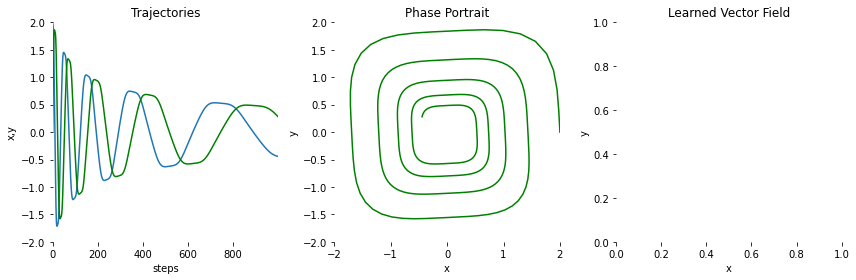

In [309]:
# fixed point
true_y0 = torch.tensor([[2., 0.]]).to(device)  # initial condition
t = torch.linspace(0., 25., data_size).to(device)  # t is from 0 to 25 for 1000 data points
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]]).to(device)  # true system dynamics of fixed point

# system dynamics
class FixedPoint(nn.Module):
    def forward(self, t, y):
        return torch.mm(y**3, true_A)  # true system derivatives

# generating training data
with torch.no_grad():
    true_fixed_point = odeint(FixedPoint(), true_y0, t, method='dopri5')

visualize_2d(true_y=true_fixed_point.detach().numpy())

In [302]:
pred_traj.shape
true_fixed_point.squeeze().detach().numpy().shape

(1000, 2)

## Lorenz

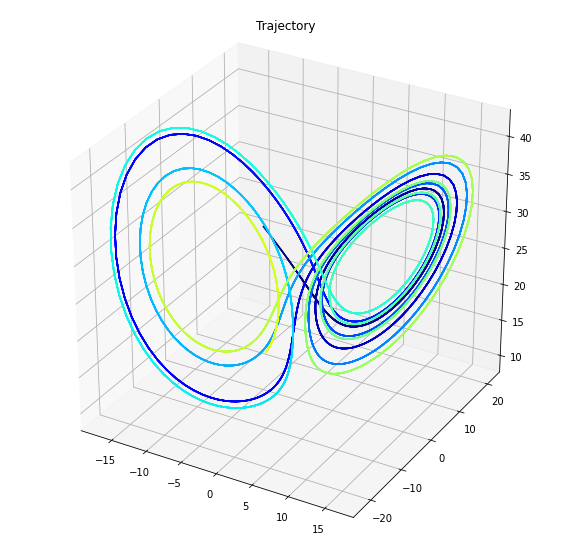

In [38]:
# lorenz system dynamics
class Lorenz(nn.Module):
    """
    chaotic lorenz system
    """
    def __init__(self):
        super(Lorenz, self).__init__()
        self.lin = nn.Linear(5, 3, bias=False)
        W = torch.tensor([[-10., 10., 0., 0., 0.],
                          [28., -1., 0., -1., 0.],
                          [0., 0., -8. / 3., 0., 1.]])
        self.lin.weight = nn.Parameter(W)

    def forward(self, t, x):
        y = y = torch.ones([1, 5])
        y[0][0] = x[0][0]
        y[0][1] = x[0][1]
        y[0][2] = x[0][2]
        y[0][3] = x[0][0] * x[0][2]
        y[0][4] = x[0][0] * x[0][1]
        return self.lin(y)

true_y0 = torch.tensor([[-8., 7., 27.]]).to(device)  # initial condition
t = torch.linspace(0., 10., data_size).to(device)  # t is from 0 to 25 for 1000 data points

# generating training data
with torch.no_grad():
    true_lorenz = odeint(Lorenz(), true_y0, t, method='rk4')

visualize_3d(noiseless_traj=true_lorenz)

# RNN model

In [287]:
class fcRNN(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size, n_layers):
    super(fcRNN, self).__init__()
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers
    self.rnn = nn.RNN(input_size, 
                      hidden_dim, n_layers, 
                      nonlinearity='relu',
                      batch_first=True) # RNN hidden units
    self.fc = nn.Linear(hidden_dim, output_size) # output layer

  def forward(self, x):
    bs, _, _ = x.shape
    h0 = torch.zeros(self.n_layers, bs, self.hidden_dim).requires_grad_().to(device)
    out, hidden = self.rnn(x, h0.detach())
    out = out.view(bs, -1, self.hidden_dim)
    out = self.fc(out)
    return out[:, -1, :]

# Training

In [271]:
def create_inout_sequences(input_data, tw):
    train_data = []
    labels = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        train_data.append(torch.FloatTensor(train_seq).squeeze(1).unsqueeze(0))
        labels.append(torch.FloatTensor(train_label).squeeze(1).unsqueeze(0))

    return torch.cat(train_data, 0), torch.cat(labels, 0)

## Training loop

In [ ]:
system = "lorenz"  # choose "lorenz" or "fixed_point"
if system == "lorenz":
    observations = true_lorenz
elif system == "fixed_point":
    observations = true_fixed_point

feature_size = observations.shape[2]
model = fcRNN(feature_size, 128, feature_size, 2)

In [286]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print("Model has a total of {0} parameters.".format(pytorch_total_params))

Model has a total of 50435 parameters.


In [281]:
train_window = 10
# generating training data and labels for RNN
data_train, labels = create_inout_sequences(observations, train_window)
data_train.shape
epochs = 1000
loss_arr = []
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

# training loop
for i in range(epochs):
    if i > 800:
        optimizer.param_groups[0]['lr'] = 1e-3
    optimizer.zero_grad()
    y_pred = model(data_train)
    #print(y_pred.shape)
    loss = loss_function(y_pred, labels.squeeze())
    loss.backward()
    optimizer.step()
    
    loss_arr.append(loss.item())
    if i%50 == 0:
        print(f'epoch: {i:3} loss: {loss_arr[-1]:10.8f}')

print(f'epoch: {i:3} loss: {loss_arr[-1]:10.10f}')

epoch:   0 loss: 0.00583188
epoch:  50 loss: 0.12268630
epoch: 100 loss: 0.02203764
epoch: 150 loss: 0.01318241
epoch: 200 loss: 0.01777009
epoch: 250 loss: 0.03205470
epoch: 300 loss: 0.15200891
epoch: 350 loss: 0.00470462
epoch: 400 loss: 0.00967351
epoch: 450 loss: 0.00365379
epoch: 500 loss: 0.00314022
epoch: 550 loss: 0.05590281
epoch: 600 loss: 0.00302171
epoch: 650 loss: 0.01965337
epoch: 700 loss: 0.00328349
epoch: 750 loss: 0.00208735
epoch: 800 loss: 0.00980101
epoch: 850 loss: 0.00227583
epoch: 900 loss: 0.00211219
epoch: 950 loss: 0.00201375
epoch: 999 loss: 0.0019486322


# Evaluation

In [282]:
########## Predicting with RNN ##########
pred_len = 1000
test_inputs = data_train[0].squeeze().detach().numpy()
pred_traj = []
for i in range(train_window):
    pred_traj.append(test_inputs[i])

with torch.no_grad():
    for i in range(pred_len):
        seq = torch.tensor(np.array(pred_traj).squeeze()[-train_window:])
        model_out = model(seq.unsqueeze(0)).squeeze().detach().numpy().reshape(-1)
        pred_traj.append(model_out)
pred_traj = np.array(pred_traj)

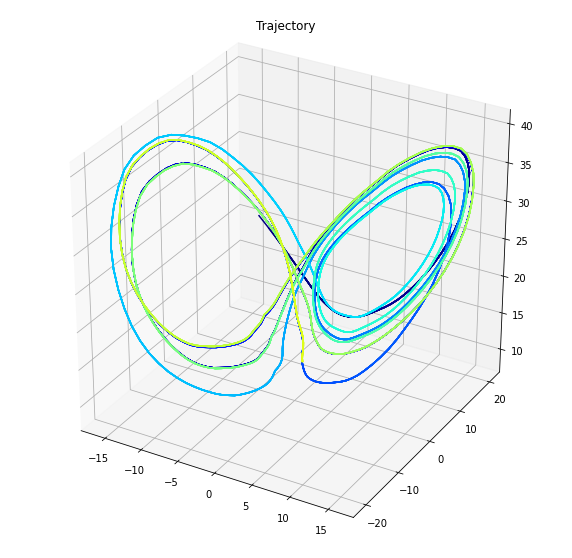

In [283]:
if system == "lorenz":
    visualize_3d(noiseless_traj=pred_traj)
elif system == "fixed_point":
    visualize_2d(pred_y=np.expand_dims(pred_traj, 1))